In [1]:
!pip install patchify

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import from_bounds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
from patchify import patchify

import torch
from torch.functional import F
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
import fiona
from shapely.geometry import shape
import cv2
from pytorch_segmentation.utils.postprocessing import mosaic_to_raster
from pytorch_segmentation.data.inference_dataset import SatInferenceDataset
#from pytorch_segmentation.utils.preprocessing import unpatchify,pad_image_topleft


seed = 42

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


patch_size = [256,256,3] # [x,y,bands]
overlap = 128
padding = 64

bval = (255,255,255)
nworkers = 4
bs = 16

dataset_path = "data/datasets/inference_data.pkl"
data_path = "/home/jovyan/work/satellite_data/tmp/2018.vrt"
#data_path = "/home/jovyan/work/satellite_data/tmp/27/2018_cog.tif"
shape_path = "data/areas/test"
model_path = "saved_models/unet_07_04_2022_094905.pth" #unet_15_03_2022_071331.pth" #unet_24_03_2022_064749.pth

# 1. Data Loading and Preprocessing

In [2]:

dataset = SatInferenceDataset(data_file_path=data_path,shape_path=shape_path,overlap=128,padding=64)
shapes = dataset.shapes.copy()
dataset.save(dataset_path)

del dataset


# 2. UNet 


# 2.2 Unet

In [3]:
from pytorch_segmentation.models import UNet
net = UNet(n_channels=patch_size[2], n_classes=2, bilinear=False)
net.load_state_dict(torch.load(model_path))
#net = net.to(device)
net.eval();



## Single Process 

In [ ]:
mosaic_to_raster(dataset,net,"data/out/",device_ids=[0,1,2,3,4],bs=650,pin_memory=True,num_workers=20)

# Multi Process

In [ ]:
from pytorch_segmentation.utils.postprocessing import mosaic_to_raster_mp
mosaic_to_raster_mp(dataset_path,net,"data/out/",device_ids=[0,2,3,4],bs=150,pin_memory=True,num_workers=8)

## Multi Process Queue

In [ ]:
from pytorch_segmentation.utils.postprocessing import mosaic_to_raster_mp_queue
mosaic_to_raster_mp_queue(dataset_path,net,"data/out/",mmap_shape=(len_dataset,256,256),device_ids=[0,1,2,3,4],
                          bs=150,pin_memory=True,num_workers=10)

# Multi Process Queue In-Memory

In [ ]:
from pytorch_segmentation.utils.postprocessing import mosaic_to_raster_mp_queue_memory
mosaic_to_raster_mp_queue_memory(dataset_path,shapes,net,"data/out/",device_ids=[0,1,2,3,4],
                          bs=150,pin_memory=True,num_workers=10)

  0%|          | 0/15541 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 3
Start GPU: 4
Start GPU: 2


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|          | 21/15541 [00:38<4:10:03,  1.03it/s]

Start GPU: 1


  5%|▌         | 810/15541 [16:46<5:18:15,  1.30s/it] 

In [63]:
patches = np.random.randint(255,size=(150,255,255))
shape = dataset.shapes.iloc[0]
memory = rasterio.MemoryFile()

out_transform = shape["transform"]
out_meta = shape["sat_meta"]

height = shape["height"]
width = shape["width"]
out_meta.update({"driver": "GTiff",
                "count":1,
                "height": height,
                "width": width,
                "transform": out_transform,
                "compress":"DEFLATE"})
mfile = memory.open(**out_meta)

start_idx = np.array([644])
ny,nx = shape["grid_shape"]
ypad,ypad_extra,xpad,xpad_extra = shape["padding"]    

patch_size = patches[0].shape
grid = np.arange(ny*nx).reshape(ny,nx)
y,x = np.where(grid == start_idx)

col_off = (patch_size[0] - xpad*2) * x  
row_off = (patch_size[1] - ypad*2) * y

In [65]:
from rasterio.windows import Window
for i in range(len(patches)):
    img = patches[i]

    co,ro = 0,0
    if (x != nx-1) and (y != ny-1):
        cropped_img = img[ypad:img.shape[0]-ypad,xpad:img.shape[1]-xpad]
        co = cropped_img.shape[1]
        x += 1
    elif (x == nx-1) and (y != ny-1):
        cropped_img = img[ypad:img.shape[0]-ypad,xpad:img.shape[1]-xpad_extra]
        ro = cropped_img.shape[0]
        co = -col_off
        x = 0
        y += 1
    elif (x != nx-1) and (y == ny-1):
        cropped_img = img[ypad:img.shape[0]-ypad_extra,xpad:img.shape[1]-xpad]
        co = cropped_img.shape[1]
        x += 1
    elif (x == nx-1) and (y == ny-1):
        cropped_img = img[ypad:img.shape[0]-ypad_extra,xpad:img.shape[1]-xpad_extra]
    win = Window(row_off=row_off,col_off=col_off,
                    width=cropped_img.shape[1],height=cropped_img.shape[0])

    mfile.write(cropped_img,window=win,indexes=1)
    col_off += co
    row_off += ro

.....
0
[15]
[18]
[2286]
[1778]
.....
1
[16]
[18]
[2286]
[1905]
.....
2
[17]
[18]
[2286]
[2032]
.....
3
[18]
[18]
[2286]
[2159]
.....
4
[19]
[18]
[2286]
[2286]
.....
5
[20]
[18]
[2286]
[2413]
.....
6
[21]
[18]
[2286]
[2540]
.....
7
[22]
[18]
[2286]
[2667]
.....
8
[23]
[18]
[2286]
[2794]
.....
9
[24]
[18]
[2286]
[2921]
.....
10
[25]
[18]
[2286]
[3048]
.....
11
[26]
[18]
[2286]
[3175]
.....
12
[27]
[18]
[2286]
[3302]
.....
13
[28]
[18]
[2286]
[3429]
.....
14
[29]
[18]
[2286]
[3556]
.....
15
[30]
[18]
[2286]
[3683]
.....
16
[31]
[18]
[2286]
[3810]
.....
17
[32]
[18]
[2286]
[3937]
.....
18
[33]
[18]
[2286]
[4064]
.....
19
[34]
[18]
[2286]
[4191]
.....
20
0
[19]
[2286]
[4318]
.....
21
1
[19]
[2413]
[0]
.....
22
2
[19]
[2413]
[127]
.....
23
3
[19]
[2413]
[254]
.....
24
4
[19]
[2413]
[381]
.....
25
5
[19]
[2413]
[508]
.....
26
6
[19]
[2413]
[635]
.....
27
7
[19]
[2413]
[762]
.....
28
8
[19]
[2413]
[889]
.....
29
9
[19]
[2413]
[1016]
.....
30
10
[19]
[2413]
[1143]
.....
31
11
[19]
[2413]
[1270

In [49]:
from rasterio.windows import Window
def test():
    i = 0
    p_idx = 0
    col_off,row_off  = 0,0
    for y in range(ny):
        for x in range(nx):
            if i >= start_idx:
                img = patches[p_idx]
                p_idx += 1
                if p_idx == len(patches):
                    return
            else:
                img = np.random.randint(1,size=patches[0].shape)

            if img is None:
                print(i)
            co,ro = 0,0
            if (x != nx-1) and (y != ny-1):
                cropped_img = img[ypad:img.shape[0]-ypad,xpad:img.shape[1]-xpad]
                co = cropped_img.shape[1]
            if (x == nx-1) and (y != ny-1):
                cropped_img = img[ypad:img.shape[0]-ypad,xpad:img.shape[1]-xpad_extra]
                ro = cropped_img.shape[0]
                co = -col_off
            if (x != nx-1) and (y == ny-1):
                cropped_img = img[ypad:img.shape[0]-ypad_extra,xpad:img.shape[1]-xpad]
                co = cropped_img.shape[1]
            if (x == nx-1) and (y == ny-1):
                cropped_img = img[ypad:img.shape[0]-ypad_extra,xpad:img.shape[1]-xpad_extra]
            if i >= start_idx:
                print(p_idx)
                print(y)
                print(x)
                print(col_off)
                print(row_off)
                print("-----")
                win = Window(row_off=row_off,col_off=col_off,
                            width=cropped_img.shape[1],height=cropped_img.shape[0])
                mfile.write(cropped_img,window=win,indexes=1)
            i += 1
            col_off += co
            row_off += ro

In [50]:
test()

1
18
14
1778
2286
-----
2
18
15
1905
2286
-----
3
18
16
2032
2286
-----
4
18
17
2159
2286
-----
5
18
18
2286
2286
-----
6
18
19
2413
2286
-----
7
18
20
2540
2286
-----
8
18
21
2667
2286
-----
9
18
22
2794
2286
-----
10
18
23
2921
2286
-----
11
18
24
3048
2286
-----
12
18
25
3175
2286
-----
13
18
26
3302
2286
-----
14
18
27
3429
2286
-----
15
18
28
3556
2286
-----
16
18
29
3683
2286
-----
17
18
30
3810
2286
-----
18
18
31
3937
2286
-----
19
18
32
4064
2286
-----
20
18
33
4191
2286
-----
21
18
34
4318
2286
-----
22
19
0
0
2413
-----
23
19
1
127
2413
-----
24
19
2
254
2413
-----
25
19
3
381
2413
-----
26
19
4
508
2413
-----
27
19
5
635
2413
-----
28
19
6
762
2413
-----
29
19
7
889
2413
-----
30
19
8
1016
2413
-----
31
19
9
1143
2413
-----
32
19
10
1270
2413
-----
33
19
11
1397
2413
-----
34
19
12
1524
2413
-----
35
19
13
1651
2413
-----
36
19
14
1778
2413
-----
37
19
15
1905
2413
-----
38
19
16
2032
2413
-----
39
19
17
2159
2413
-----
40
19
18
2286
2413
-----
41
19
19
2413
2413
-----
42
1

In [32]:
mfile[0]

TypeError: 'DatasetWriter' object is not subscriptable

In [6]:
col_off

array([3438])

In [7]:
row_off

array([2674])

In [6]:
np.where(grid == start_idx)

(array([18]), array([14]))

In [20]:
col_off = (patch_size[0] - xpad) * col

In [21]:
row_off = (patch_size[1] - ypad) * row

In [22]:
col_off

array([2674])

In [23]:
row_off

array([3438])

# Backlog

## 2.1. Simple Unet
https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705

In [ ]:
from pytorch_segmentation.models.unet_simple import UNet

net = UNet(patch_size[2],2)
net = net.load_state_dict(torch.load(model_path)).to(device)
net.eval()

In [11]:
output = []
#out = net(X.to(device))
for i,batch in enumerate(dl):
    x = batch.to(device)#[0].to(device)
    out = net(x)
    out = F.softmax(out,dim=1)
    out = torch.argmax(out,dim=1)
    out = out.cpu().numpy().astype("uint8")
    output.append(out)
imgs = np.vstack(output)

In [8]:
out_image = unpatchify(imgs,patches.shape[:2],pad)
out_meta = satellite_img.meta.copy()
out_meta.update({"driver": "GTiff",
                 "count":1,
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": sat_patch_arr_transform})
with rasterio.open(out_file, "w", **out_meta) as dest:
    dest.write(out_image)

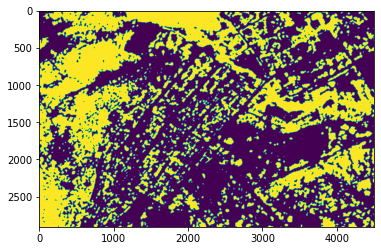

In [9]:
show(out_image);

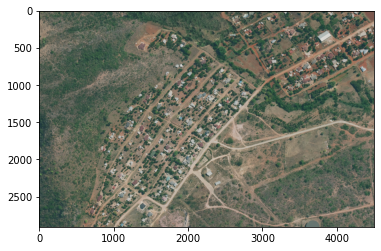

In [10]:
show(sat_patch_arr);

In [16]:
out_image = sat_patch_arr
out_meta = satellite_img.meta.copy()
out_meta.update({"driver": "GTiff",
                 "count":3,
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": sat_patch_arr_transform})
with rasterio.open('data/out/raster.tif', "w", **out_meta) as dest:
    dest.write(out_image)